# **Abstract:**

Data Science has been an integral part of Sports Analysis and Machine learning has been the most helpful way in the mordern Cricket to provide the teams more insights about their performances with data analytics. In the following project our Data Science goal will be to use a clustering algorithm for finding replacements for similar players. After reading and cleaning the data this notebook's flow goes from the tranformations to modeling and results. The Players that were found to be the best replacement for Virat Kohli according to the following IPL statistics were Suresh Raina, Rohit Sharma and Gautam Gambhir.

# **Business Problem**

Indian Premier League is one of the biggest national cricket tournaments in the world. It has 8 teams in total each year and there is an auction for players every year. There is always an issue of injury in sports which calls for a player replacement. For Team management as a data scientist it is our duty to reduce this problem by providing them with a list of players for possible replacement.  We will use Clustering algorithm in this case to determine all players who can be a possible replacement for a player. In this case we will take the example of the Indian Team Captain Virat Kohli and try to find a replacement for him.  

# **Data Dictonary:**


This data is of Indian Premier League from 2008 to year 2016. The Contributor in this case was HarshVardhan who uploaded this dataset on Kaggle. This data has insights for players for each deliveries which helps us have an indepth analysis for their strike rate and experience for the last 8 years.


Source: http://cricsheet.org (data is available on this website in the YAML format. This is converted to CSV format by the contributors)


Data Source and dictonary: https://www.kaggle.com/harsha547/indian-premier-league-csv-dataset

We will be using three files which are Match.csv, Player.csv, and ball_by_ball.csv for this project. 






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Reading the Data.**

In [3]:
Match_df= pd.read_csv('/content/drive/My Drive/Match.csv')
Match_df.head()

,Match_Id,Match_Date,Team_Name_Id,Opponent_Team_Id,Season_Id,Venue_Name,Toss_Winner_Id,Toss_Decision,IS_Superover,IS_Result,Is_DuckWorthLewis,Win_Type,Won_By,Match_Winner_Id,Man_Of_The_Match_Id,First_Umpire_Id,Second_Umpire_Id,City_Name,Host_Country
0,335987,18-Apr-08,2,1,1,M Chinnaswamy Stadium,2,field,0,1,0,by runs,140.0,1.0,2.0,470,477,Bangalore,India
1,335988,19-Apr-08,4,3,1,"Punjab Cricket Association Stadium, Mohali",3,bat,0,1,0,by runs,33.0,3.0,19.0,471,487,Chandigarh,India
2,335989,19-Apr-08,6,5,1,Feroz Shah Kotla,5,bat,0,1,0,by wickets,9.0,6.0,90.0,472,512,Delhi,India
3,335990,20-Apr-08,7,2,1,Wankhede Stadium,7,bat,0,1,0,by wickets,5.0,2.0,11.0,473,476,Mumbai,India
4,335991,20-Apr-08,1,8,1,Eden Gardens,8,bat,0,1,0,by wickets,5.0,1.0,4.0,474,486,Kolkata,India


In [4]:
Player_df= pd.read_csv('/content/drive/My Drive/Player.csv')
Player_df.head()

,Player_Id,Player_Name,DOB,Batting_Hand,Bowling_Skill,Country,Is_Umpire,Unnamed: 7
0,1,SC Ganguly,8-Jul-72,Left_Hand,Right-arm medium,India,0,NaN
1,2,BB McCullum,27-Sep-81,Right_Hand,Right-arm medium,New Zealand,0,NaN
2,3,RT Ponting,19-Dec-74,Right_Hand,Right-arm medium,Australia,0,NaN
3,4,DJ Hussey,15-Jul-77,Right_Hand,Right-arm offbreak,Australia,0,NaN
4,5,Mohammad Hafeez,17-Oct-80,Right_Hand,Right-arm offbreak,Pakistan,0,NaN


In [5]:
Player_df.isnull().sum()

Player_Id          0
Player_Name        0
DOB               52
Batting_Hand      52
Bowling_Skill     96
Country            0
Is_Umpire          0
Unnamed: 7       511
dtype: int64

There are a few null values but they are in the columns which are not relevant to our use. So we will drop those columns.

Dropping the columns that are not useful for our analysis that are "Is_Umpire, "Unnamed:7", "DOB".

---



In [6]:
Player_df=Player_df.drop(['Is_Umpire',	'Unnamed: 7','DOB'],axis=1)
Player_df.head()

,Player_Id,Player_Name,Batting_Hand,Bowling_Skill,Country
0,1,SC Ganguly,Left_Hand,Right-arm medium,India
1,2,BB McCullum,Right_Hand,Right-arm medium,New Zealand
2,3,RT Ponting,Right_Hand,Right-arm medium,Australia
3,4,DJ Hussey,Right_Hand,Right-arm offbreak,Australia
4,5,Mohammad Hafeez,Right_Hand,Right-arm offbreak,Pakistan


In [7]:
ball_by_ball_df= pd.read_csv('/content/drive/My Drive/Ball_by_Ball.csv')
ball_by_ball_df.head()

,Match_Id,Innings_Id,Over_Id,Ball_Id,Team_Batting_Id,Team_Bowling_Id,Striker_Id,Striker_Batting_Position,Non_Striker_Id,Bowler_Id,Batsman_Scored,Extra_Type,Extra_Runs,Player_dissimal_Id,Dissimal_Type,Fielder_Id
0,335987,1,1,1,1,2,1,1,2,14,0,legbyes,1,,,
1,335987,1,1,2,1,2,2,2,1,14,0,,,,,
2,335987,1,1,3,1,2,2,2,1,14,0,wides,1,,,
3,335987,1,1,4,1,2,2,2,1,14,0,,,,,
4,335987,1,1,5,1,2,2,2,1,14,0,,,,,


In [8]:
ball_by_ball_df.shape

(136590, 16)

There are 16 columns in the ball_by_ball field. The aim is to find the best replacement and this data frame have statistics of the bowler throwing balls and the runs scored by batsman. Not all the columns are relevant. Thus dropping some of the columns.

In [9]:
#Only selecting the following columns as this is the nly columns helps to decide the statistics of the player.
#The number of bowls baller throwed and the number of scores batsman achieved. 
# Also which bowler gave how many runs and which batman played against the bowler. All the information can be calculated by this.
ball_by_ball_df=ball_by_ball_df[['Match_Id','Batsman_Scored','Extra_Runs', 'Bowler_Id', 'Over_Id', 'Striker_Id']]
ball_by_ball_df.head()

,Match_Id,Batsman_Scored,Extra_Runs,Bowler_Id,Over_Id,Striker_Id
0,335987,0,1,14,1,1
1,335987,0,,14,1,2
2,335987,0,1,14,1,2
3,335987,0,,14,1,2
4,335987,0,,14,1,2


Checking the Data Types of the columns and looking for null values.



In [10]:
ball_by_ball_df.dtypes

Match_Id           int64
Batsman_Scored    object
Extra_Runs        object
Bowler_Id          int64
Over_Id            int64
Striker_Id         int64
dtype: object

In [11]:
#https://stackoverflow.com/questions/40790031/pandas-to-numeric-find-out-which-string-it-was-unable-to-parse
ball_by_ball_df["Batsman_Scored"] = pd.to_numeric(ball_by_ball_df["Batsman_Scored"], errors="coerce")
ball_by_ball_df["Extra_Runs"] = pd.to_numeric(ball_by_ball_df["Extra_Runs"], errors="coerce")

In [12]:
#checking for null values
ball_by_ball_df.isnull().sum()

Match_Id               0
Batsman_Scored        26
Extra_Runs        130330
Bowler_Id              0
Over_Id                0
Striker_Id             0
dtype: int64

It is evident from that some columns have null values.
The field 'Extra_Runs' is empty when there are no extra runs. Thus it is better to field them with zero.

In [13]:
ball_by_ball_df["Batsman_Scored"] = ball_by_ball_df["Batsman_Scored"].fillna(0)
ball_by_ball_df["Extra_Runs"] = ball_by_ball_df["Extra_Runs"].fillna(0)

# **Transformations and Experiments**

The goal of the project is to find the replacement for the batsmen. Thus, now creating a new dataframe that will have batsmen Id, number of runs scored and number of balls the player has played. The strike rate of batsmen is also calculated in the dataframe. 

In [15]:
#Appending the values in a list
no_of_runs = []
no_of_balls_played = []
unique_batsmen_id= ball_by_ball_df["Striker_Id"].unique()
for i in unique_batsmen_id:
    run = ball_by_ball_df["Batsman_Scored"][ball_by_ball_df["Striker_Id"] == i].sum()
    ball = ball_by_ball_df["Match_Id"][ball_by_ball_df["Striker_Id"] == i].count()
    no_of_runs.append(run)
    no_of_balls_played.append(ball)

#Creating a new dataframe with all the players and the number of balls played, runs scored, strike rate.
batsmen_df = pd.DataFrame({"Player_names": ball_by_ball_df["Striker_Id"].unique()})

batsmen_df["Runs"] = no_of_runs
batsmen_df["Balls_played"] = no_of_balls_played

Calculating Strike rate of a batsman is very importannt is understanding how he is performing. 


Strike Rate of a Batsman is the number of runs scored by a batsmen in 100 balls. For this we will calculate the number of runs and multiply them by 100 and divide the equation by the number of balls played. 


In [18]:
batsmen_df["Strike_Rate"] = (batsmen_df["Runs"] * 100 / batsmen_df["Balls_played"]).round(2)

#Eliminating batsmen with low strike rates as they will be lower order batsmen who are probably bowlers.

batsmen_df = batsmen_df[batsmen_df["Strike_Rate"] > 50]

#It is important to filter players who have played atleast an over and scored runs more than 6 in an over. (One Run a ball atleast )
batsmen_df = batsmen_df[(batsmen_df["Runs"]*6/batsmen_df["Balls_played"]) > 6]

batsmen_df.head()

,Player_names,Runs,Balls_played,Strike_Rate
0,1,1349.0,1326,101.73
1,2,2435.0,1954,124.62
3,4,1322.0,1101,120.07
5,6,2170.0,1918,113.14
6,7,130.0,129,100.78


We will rename the column name for merging the two dataframes for identifying the players name from their player id.

In [20]:
batsmen_df = batsmen_df.rename(columns={"Player_names": "Player_Id"})
batsmen_df = batsmen_df[batsmen_df.columns].merge(Player_df, "left")
batsmen_df.head()

,Player_Id,Runs,Balls_played,Strike_Rate,Player_Name,Batting_Hand,Bowling_Skill,Country
0,1,1349.0,1326,101.73,SC Ganguly,Left_Hand,Right-arm medium,India
1,2,2435.0,1954,124.62,BB McCullum,Right_Hand,Right-arm medium,New Zealand
2,4,1322.0,1101,120.07,DJ Hussey,Right_Hand,Right-arm offbreak,Australia
3,6,2170.0,1918,113.14,R Dravid,Right_Hand,Right-arm offbreak,India
4,7,130.0,129,100.78,W Jaffer,Right_Hand,Right-arm offbreak,India


In [21]:
#checking the number of right and left handed batsmen
batsmen_df[batsmen_df['Batting_Hand']=='Right_Hand'].count()

Player_Id        173
Runs             173
Balls_played     173
Strike_Rate      173
Player_Name      173
Batting_Hand     173
Bowling_Skill    156
Country          173
dtype: int64

In [22]:
#checking the strikerate of the right handed batsmen
batsmen_df[batsmen_df['Batting_Hand']=='Right_Hand']['Strike_Rate']

1      124.62
2      120.07
3      113.14
4      100.78
5      126.85
        ...  
240    133.33
241    118.18
243    128.69
244    107.69
246    160.00
Name: Strike_Rate, Length: 173, dtype: float64

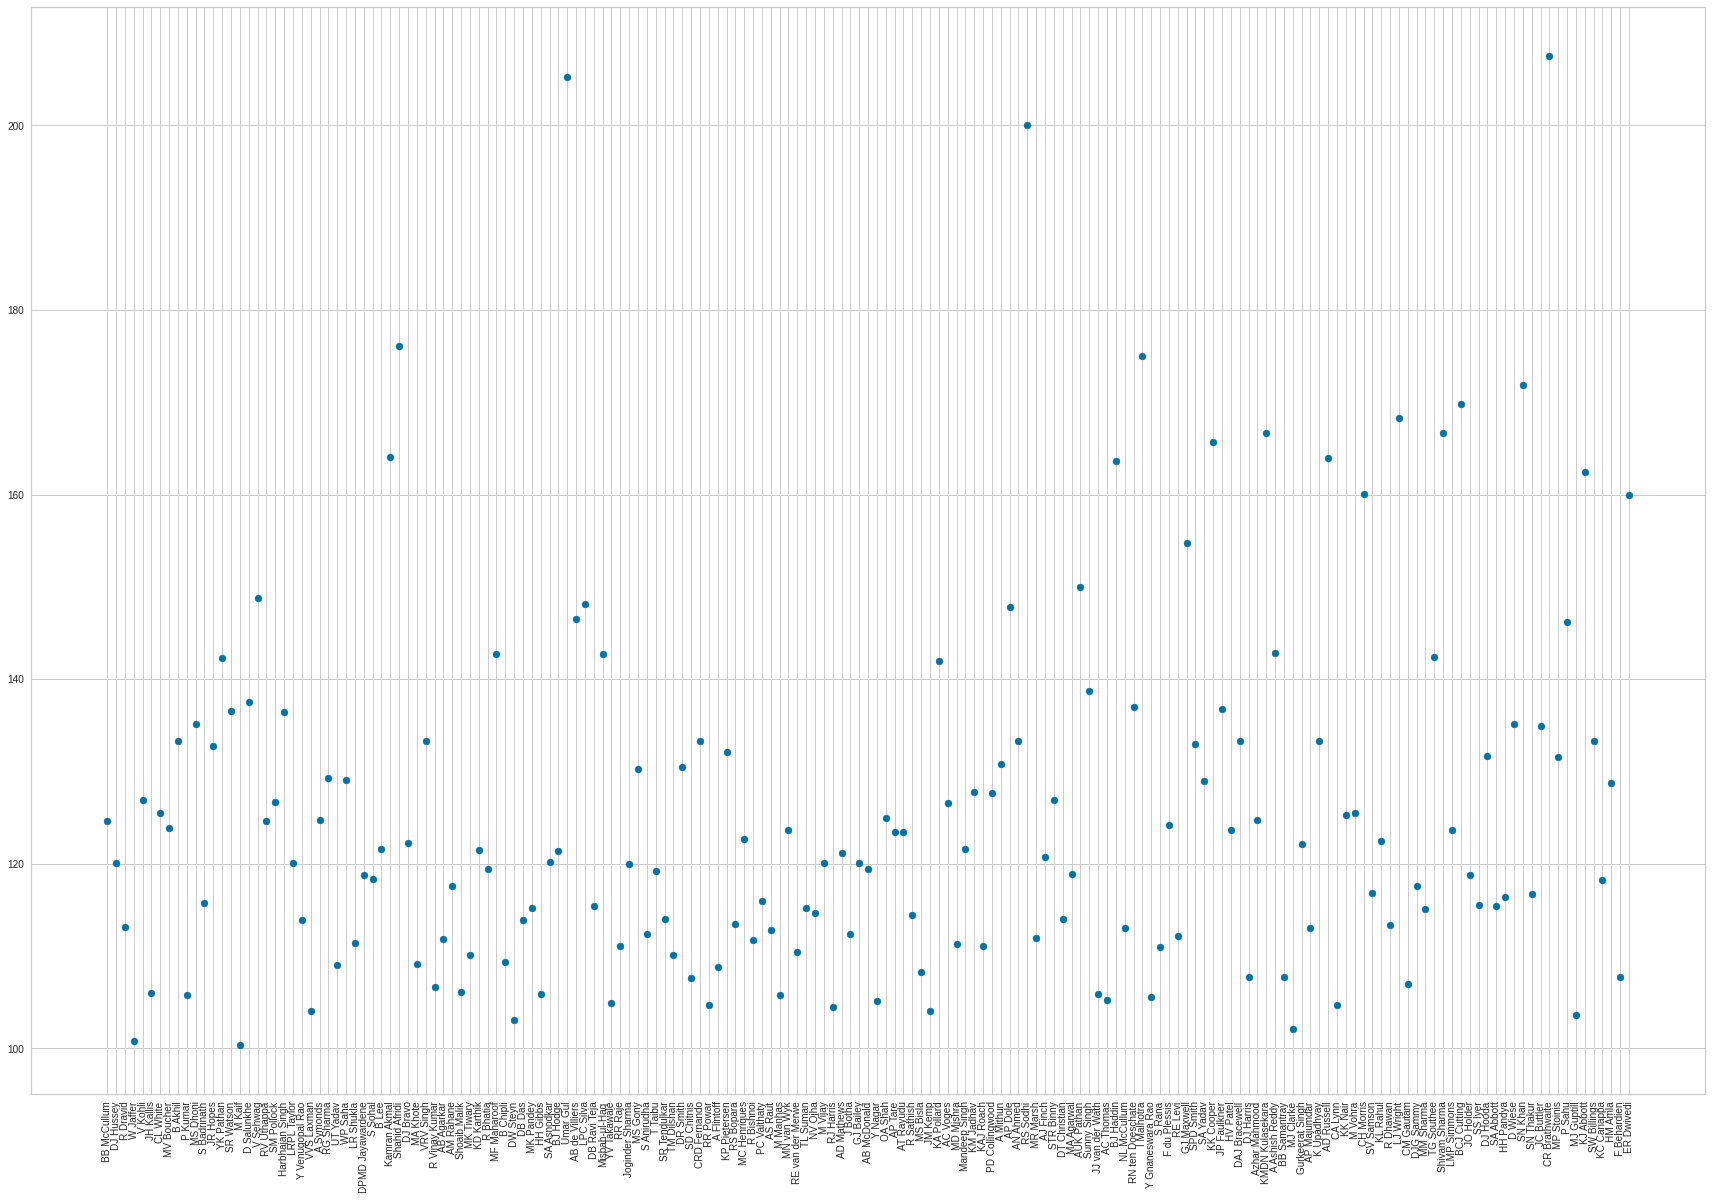

In [ ]:
#plotting the strike rate of the right handed batsmen
plt.figure(figsize=(30,20))
plt.scatter(batsmen_df[batsmen_df['Batting_Hand']=='Right_Hand']['Player_Name'], batsmen_df[batsmen_df['Batting_Hand']=='Right_Hand']['Strike_Rate'])
plt.xticks(rotation= 90)
plt.show()

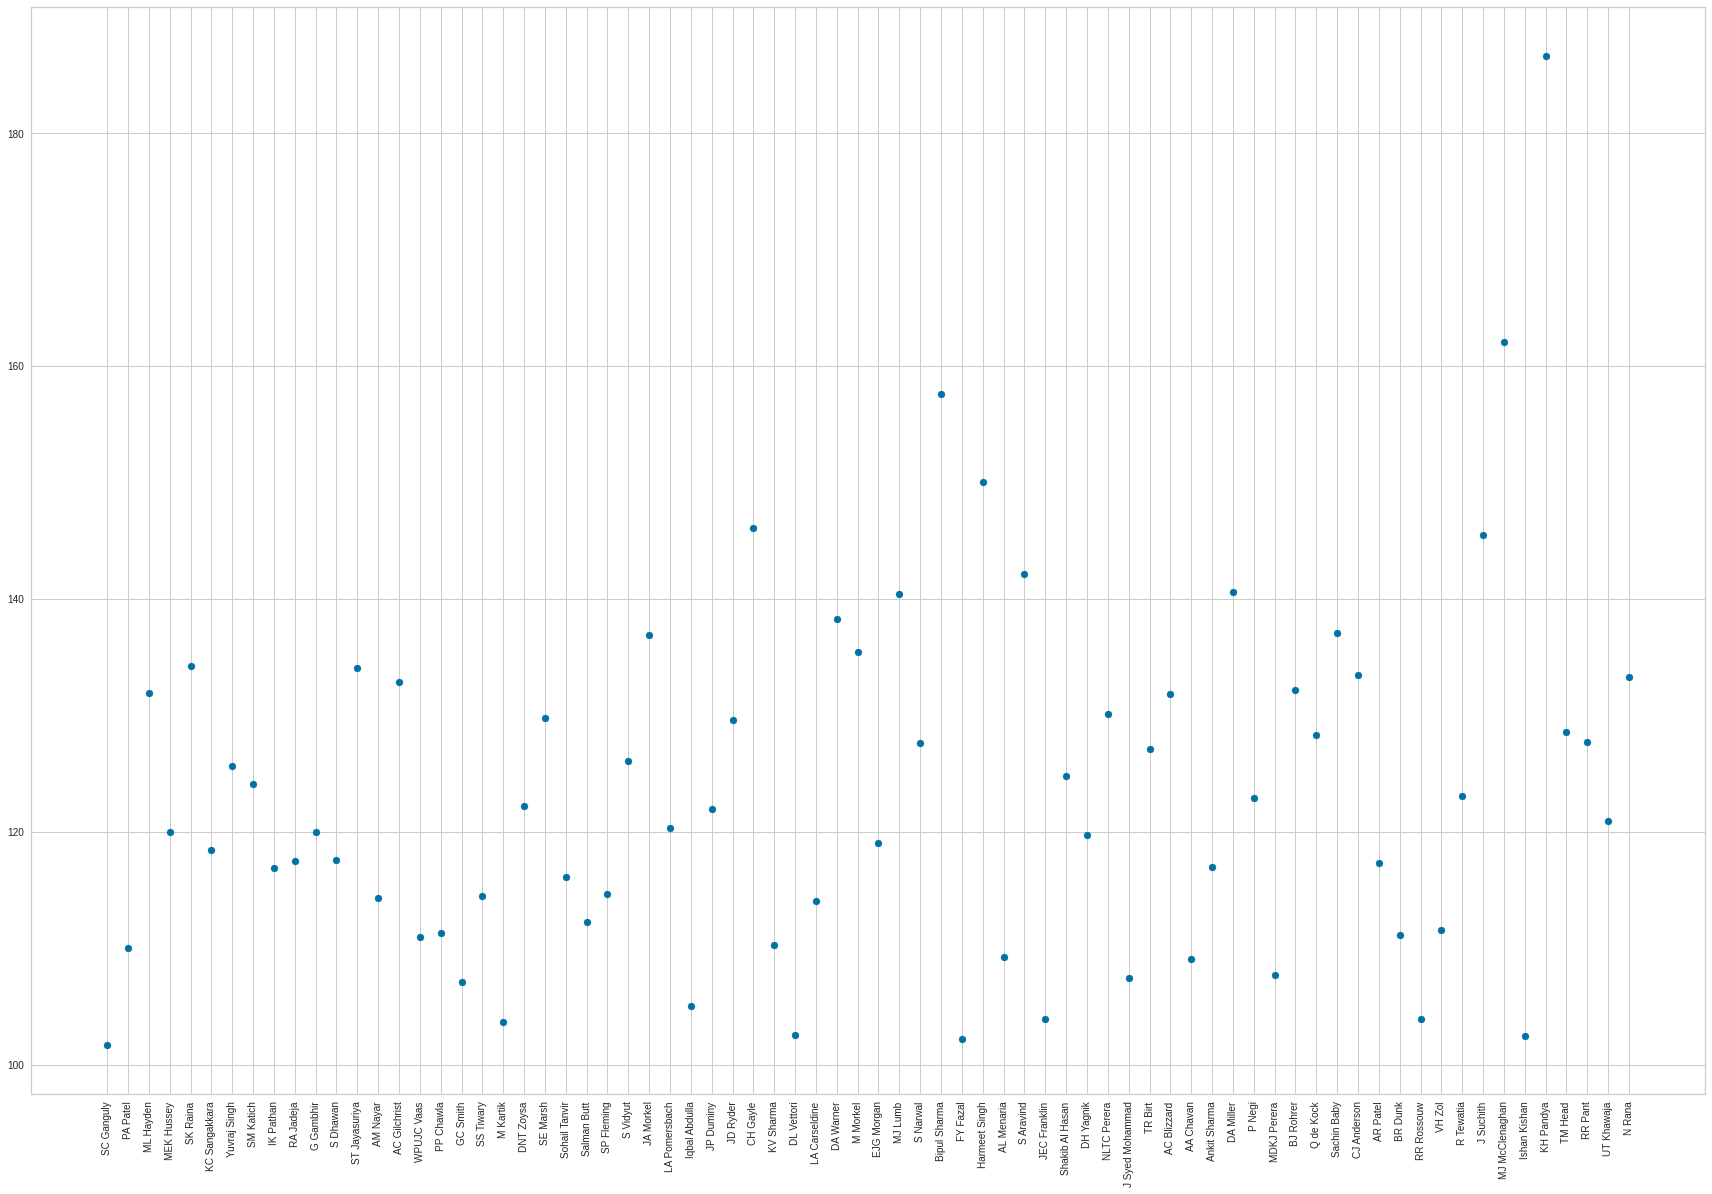

In [ ]:
#checking the strike rates of left handed batsmen
plt.figure(figsize=(30,20))
plt.scatter(batsmen_df[batsmen_df['Batting_Hand']=='Left_Hand']['Player_Name'], batsmen_df[batsmen_df['Batting_Hand']=='Left_Hand']['Strike_Rate'])
plt.xticks(rotation= 90)
plt.show()

Chceking and plotting the top 10 run scorers in these 8 years.

In [ ]:
batsmen_df.nlargest(6, 'Runs')['Player_Name']

15       SK Raina
5         V Kohli
40      RG Sharma
27      G Gambhir
103      CH Gayle
31     RV Uthappa
Name: Player_Name, dtype: object

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

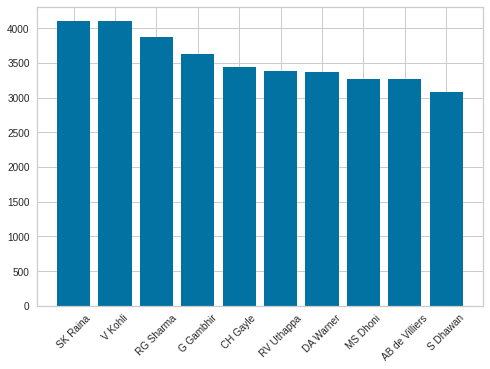

In [ ]:
plt.bar(batsmen_df.nlargest(10, 'Runs')['Player_Name'], batsmen_df.nlargest(10, 'Runs')['Runs'])
plt.xticks(rotation= 45)


Checking and Plotting the top 10 players who have faced the most number of balls.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

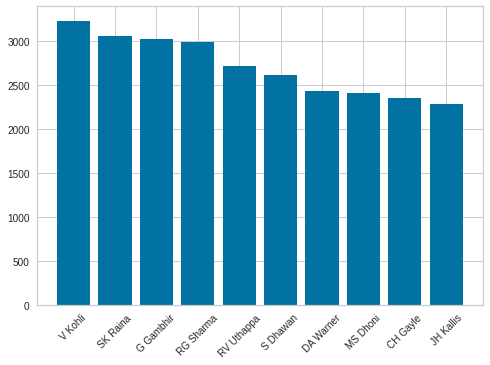

In [ ]:
plt.bar(batsmen_df.nlargest(10, 'Balls_played')['Player_Name'], batsmen_df.nlargest(10, 'Balls_played')['Balls_played'])
plt.xticks(rotation= 45)

## **Limitations and Future Works:**
The limitations in this project is that there are alot of other factors that have not been taken into consideration which are playing order of the batsmen, partnerships, grounds on which these matches have been played etc.



